In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
MF_input = np.loadtxt('dyn_MF.txt')
MF_input = MF_input*1000
MX_input = np.loadtxt('dyn_MX.txt')
MX_input = MX_input*1000

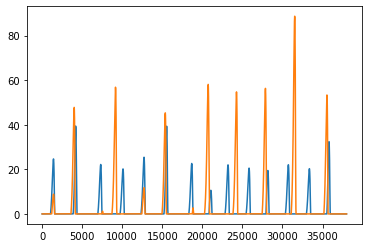

In [3]:
plt.plot(MF_input)
plt.plot(MX_input)

In [52]:
def FL_function(L):
    beta = 1.55
    omega = 0.75
    rho = 2.12
    
    FL = np.exp(-np.power(abs((np.power(L,beta) - 1)/(omega)),rho));
    return FL

def FV_con_function(L,V):
    Vmax = -9.15*2;
    cv0 = -5.7;
    cv1 = 9.18;
    
    FVcon = (Vmax - V)/(Vmax + (cv0 + cv1*L)*V);
    return FVcon

def FV_ecc_function(L,V):
    av0 = -1.4;
    av1 = 0.0;
    av2 = 0.0;
    bv = 0.72;
    FVecc = (bv - (av0 + av1*L + av2*np.power(L,2))*V)/(bv+V);
    
    return FVecc

def Fpe_function(L,V):
    c1_pe1 = 23.0*6
    k1_pe1 = 0.046
    Lr1_pe1 = 1.17
    eta = 0.0001;
    
    Fpe1 = c1_pe1 * k1_pe1 * np.log(np.exp((L - Lr1_pe1)/(k1_pe1))+1) + eta*V;
    
    return Fpe1

def Af_function(U,L):
    a = (2.0-0.5)/(1.0-0.001);
    b = 0.5-(2.0-0.5)/(1.0-0.001)*.001;
    f_eff = a*U+b;

    a_f = 0.56
    n_f0 = 2.1
    n_f1 = 3.3
    n_f = n_f0 + n_f1*(1.0/L-1.0);
    Af = 1 - np.exp(-np.power(f_eff/(a_f*n_f),n_f));
    return Af

def forward_dynamis(x,dx,u,I,B,K,Lce0_1,Lce0_2,F0_1,F0_2,Lmax_1,Lmax_2,r_m1,r_m2):
    # Minimum joint angle
    theta_min = 40*np.pi/180.0
    # Maximum joint angle
    theta_max = 110*np.pi/180.0
    
    # Muscle time constant (sec)
    tau_1 = 0.005;
    tau_2 = 0.005;
    
    Lce_1 = x[6]/Lce0_1
    Lce_2 = x[7]/Lce0_2
    Vce_1 = -r_m1*x[5]/Lce0_1
    Vce_2 = -r_m2*x[5]/Lce0_2
    
    FL_1 = FL_function(Lce_1)
    FL_2 = FL_function(Lce_1)
    
    if Vce_1 <= 0:
        FV_1 = FV_con_function(Lce_1,Vce_1)
    else:
        FV_1 = FV_ecc_function(Lce_1,Vce_1)
    if Vce_2 <= 0:
        FV_2 = FV_con_function(Lce_2,Vce_2)
    else:
        FV_2 = FV_ecc_function(Lce_2,Vce_2)
        
    Fpe_1 = Fpe_function(Lce_1/Lmax_1,Vce_1)
    Fpe_2 = Fpe_function(Lce_2/Lmax_2,Vce_2)

    Af_1 = Af_function(x[0],Lce_1)
    Af_2 = Af_function(x[2],Lce_2)
    
    #Fm_1 = (FL_1*FV_1*x[0]*Af_1+Fpe_1)*F0_1
    #Fm_2 = (FL_2*FV_2*x[2]*Af_2+Fpe_2)*F0_2
    
    Fm_1 = (FL_1*x[0]*Af_1+Fpe_1)*F0_1
    Fm_2 = (FL_2*x[2]*Af_2+Fpe_2)*F0_2
        
    T_stop_1 = 0.01*np.exp(-(x[4]-theta_min)/0.01)
    T_stop_2 = -0.01*np.exp((x[4]-theta_max)/0.01)
    
    dx[0] = x[1]
    dx[1] = -x[0]/(tau_1*tau_2) - x[1]*(tau_1+tau_2)/(tau_1*tau_2) + u[0]/(tau_1*tau_2)
    dx[2] = x[3]
    dx[3] = -x[2]/(tau_1*tau_2) - x[3]*(tau_1+tau_2)/(tau_1*tau_2) + u[1]/(tau_1*tau_2)
    dx[4] = x[5]
    dx[5] = (Fm_1*r_m1 + Fm_2*r_m2 + T_stop_1 + T_stop_2)/I - B*x[5] - K*x[4]
    dx[6] = -r_m1*x[5]
    dx[7] = -r_m2*x[5]
    return dx

def run_sim(Fs,u_1_amp,u_2_amp):
    h = 1/Fs
    duration = 0.5
    
    # Segment length
    L = 0.03 
    # Distance between the rotational axis and the center of the segment 
    d = 0
    # Segment mass
    M = 0.0004
    # Segment inertia
    I = 1/12.0*np.power(L,2)*M + np.power(d,2)*M
    # Stiffness
    K = 0.0
    # Viscosity 
    B = 100

    # Minimum joint angle
    theta_min = 40*np.pi/180.0
    # Maximum joint angle
    theta_max = 110*np.pi/180.0
    # Positive angle change => dorsiflexion 
    
    # Maximum muscle force (N)
    F0_1 = (7.64+1.52+0.35)*0.01*22.4
    F0_2 = (7.64+1.52+0.35)*0.01*22.4 #(7.43+14.57+1.42+3.67+7.3+2.15)*0.01*22.4
    # Optimal muscle fiber length
    Lce0_1 = 0.473*0.01; # Average fiber length of all dorsiflexors 
    Lce0_2 = 0.473*0.01 #0.389*0.01; # Average fiber length of all plantarflexors 
    # Maximum muscle fiber legnth at the anatomical limit of range of motion (i.e. minimum and maximum joint angles)
    Lmax_1 = 1.1;
    Lmax_2 = 1.1;

    # Muscle time constant (ms)
    tau_1 = 0.005;
    tau_2 = 0.005;

    # Moment arm (m)
    r_m1 = 0.001 #0.0006
    r_m2 = -0.001 #-0.0015
    
    dLm = -r_m1*(theta_max-theta_min)
    Lce_min_1 = (dLm + Lmax_1*Lce0_1)/Lce0_1
    dLm = -r_m2*(theta_min-theta_max)
    Lce_min_2 = (dLm + Lmax_2*Lce0_2)/Lce0_2
    
    theta_vec = np.linspace(theta_min,theta_max,1000)
    Lce_1 = np.zeros(len(theta_vec))
    Lce_1[0] = Lmax_1
    Fpe_1 = np.zeros(len(theta_vec))
    Fpe_1[0] = Fpe_function(1,0)*F0_1
    Lce_2 = np.zeros(len(theta_vec))
    Lce_2[0] = Lce_min_2
    Fpe_2 = np.zeros(len(theta_vec))
    Fpe_2[0] = Fpe_function(Lce_min_2/Lmax_2,0)*F0_2
    for i in range(1,len(theta_vec)):
        dLm_1 = -r_m1*(theta_vec[i]-theta_vec[i-1])
        Lce_1[i] = (dLm_1 + Lce_1[i-1]*Lce0_1)/Lce0_1
        Fpe_1[i] = Fpe_function(Lce_1[i]/Lmax_1,0)*F0_1

        dLm_2 = -r_m2*(theta_vec[i]-theta_vec[i-1])
        Lce_2[i] = (dLm_2 + Lce_2[i-1]*Lce0_2)/Lce0_2
        Fpe_2[i] = Fpe_function(Lce_2[i]/Lmax_2,0)*F0_2
        
    eq_theta = theta_vec[np.argmin(abs(Fpe_1*r_m1-Fpe_2*-r_m2))]
    
    # Generate step inputs to flexor and extensor
    time_sim = np.arange(0,duration,step = 1/Fs)
    u_1 = np.zeros([int(duration*Fs),1])
    u_2 = np.zeros([int(duration*Fs),1])
    u_1[int(0.1*Fs):] = u_1_amp
    u_2[int(0.1*Fs):] = u_2_amp
    
    theta = eq_theta
    dtheta = 0
    Lm_1 = Lce_1[np.argmin(abs(Fpe_1*r_m1-Fpe_2*-r_m2))]
    Lm_1 = Lm_1*Lce0_1
    Lm_2 = Lce_2[np.argmin(abs(Fpe_1*r_m1-Fpe_2*-r_m2))]
    Lm_2 = Lm_2*Lce0_2
    x = np.array([0.0, 0.0, 0.0, 0.0, theta, dtheta, Lm_1, Lm_2])
    dx = np.zeros(8)
    x_mat = np.zeros((int(duration*Fs),len(x)))
    
    t0 = time.time()
    for t in range(int(duration*Fs)):
        u = np.concatenate((u_1[t],u_2[t]))
        f1 = forward_dynamis(x,dx,u,I,B,K,Lce0_1,Lce0_2,F0_1,F0_2,Lmax_1,Lmax_2,r_m1,r_m2)
        x1 = x + f1*h/2
        f2 = forward_dynamis(x1,dx,u,I,B,K,Lce0_1,Lce0_2,F0_1,F0_2,Lmax_1,Lmax_2,r_m1,r_m2)
        x2 = x + f2*h/2
        f3 = forward_dynamis(x2,dx,u,I,B,K,Lce0_1,Lce0_2,F0_1,F0_2,Lmax_1,Lmax_2,r_m1,r_m2)
        x3 = x + f3*h
        f4 = forward_dynamis(x3,dx,u,I,B,K,Lce0_1,Lce0_2,F0_1,F0_2,Lmax_1,Lmax_2,r_m1,r_m2)
        x = x + (f1+2*f2+2*f3+f4)*h/6
        x_mat[t,:] = x

    tf = time.time()
    total = tf-t0
    #print(total)

    return x_mat 

In [30]:
Fs = 10000
h = 1/Fs
duration = len(MF_input)
time_sim = np.arange(0,duration/Fs,step = 1/Fs)

In [31]:
# Segment length
L = 0.03 
# Distance between the rotational axis and the center of the segment 
d = 0
# Segment mass
M = 0.0004
# Segment inertia
I = 1/12.0*np.power(L,2)*M + np.power(d,2)*M
# Stiffness
K = 0.0
# Viscosity 
B = 200

# Minimum joint angle
theta_min = 40*np.pi/180.0
# Maximum joint angle
theta_max = 110*np.pi/180.0
# Positive angle change => dorsiflexion 

In [32]:
# Maximum muscle force (N)
F0_1 = (7.64+1.52+0.35)*0.01*22.4
F0_2 = (7.64+1.52+0.35)*0.01*22.4 #(7.43+14.57+1.42+3.67+7.3+2.15)*0.01*22.4
# Optimal muscle fiber length
Lce0_1 = 0.473*0.01; # Average fiber length of all dorsiflexors 
Lce0_2 = 0.473*0.01 #0.389*0.01; # Average fiber length of all plantarflexors 
# Maximum muscle fiber legnth at the anatomical limit of range of motion (i.e. minimum and maximum joint angles)
Lmax_1 = 1.1;
Lmax_2 = 1.1;

# Muscle time constant (ms)
tau_1 = 0.005;
tau_2 = 0.005;

# Moment arm (m)
r_m1 = 0.001 #0.0006
r_m2 = -0.001 #-0.0015

In [33]:
dLm = -r_m1*(theta_max-theta_min)
Lce_min_1 = (dLm + Lmax_1*Lce0_1)/Lce0_1
dLm = -r_m2*(theta_min-theta_max)
Lce_min_2 = (dLm + Lmax_2*Lce0_2)/Lce0_2

theta_vec = np.linspace(theta_min,theta_max,1000)
Lce_1 = np.zeros(len(theta_vec))
Lce_1[0] = Lmax_1
Fpe_1 = np.zeros(len(theta_vec))
Fpe_1[0] = Fpe_function(1,0)*F0_1
Lce_2 = np.zeros(len(theta_vec))
Lce_2[0] = Lce_min_2
Fpe_2 = np.zeros(len(theta_vec))
Fpe_2[0] = Fpe_function(Lce_min_2/Lmax_2,0)*F0_2
for i in range(1,len(theta_vec)):
    dLm_1 = -r_m1*(theta_vec[i]-theta_vec[i-1])
    Lce_1[i] = (dLm_1 + Lce_1[i-1]*Lce0_1)/Lce0_1
    Fpe_1[i] = Fpe_function(Lce_1[i]/Lmax_1,0)*F0_1
    
    dLm_2 = -r_m2*(theta_vec[i]-theta_vec[i-1])
    Lce_2[i] = (dLm_2 + Lce_2[i-1]*Lce0_2)/Lce0_2
    Fpe_2[i] = Fpe_function(Lce_2[i]/Lmax_2,0)*F0_2
eq_theta = theta_vec[np.argmin(abs(Fpe_1*r_m1-Fpe_2*-r_m2))]
eq_theta*180/np.pi

74.96496496496496

In [60]:
theta = eq_theta
dtheta = 0
Lm_1 = Lce_1[np.argmin(abs(Fpe_1*r_m1-Fpe_2*-r_m2))]
Lm_1 = Lm_1*Lce0_1
Lm_2 = Lce_2[np.argmin(abs(Fpe_1*r_m1-Fpe_2*-r_m2))]
Lm_2 = Lm_2*Lce0_2
x = np.array([0.0, 0.0, 0.0, 0.0, theta, dtheta, Lm_1, Lm_2])
dx = np.zeros(8)
x_mat = np.zeros((int(duration),len(x)))

In [61]:
u_1 = MF_input/200
u_2 = MX_input/200

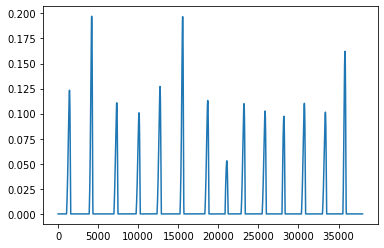

In [62]:
plt.plot(u_1)

In [63]:
t0 = time.time()
for t in range(int(duration)):
    u = np.concatenate(([u_1[t]],[u_2[t]]))
    f1 = forward_dynamis(x,dx,u,I,B,K,Lce0_1,Lce0_2,F0_1,F0_2,Lmax_1,Lmax_2,r_m1,r_m2)
    x1 = x + f1*h/2
    f2 = forward_dynamis(x1,dx,u,I,B,K,Lce0_1,Lce0_2,F0_1,F0_2,Lmax_1,Lmax_2,r_m1,r_m2)
    x2 = x + f2*h/2
    f3 = forward_dynamis(x2,dx,u,I,B,K,Lce0_1,Lce0_2,F0_1,F0_2,Lmax_1,Lmax_2,r_m1,r_m2)
    x3 = x + f3*h
    f4 = forward_dynamis(x3,dx,u,I,B,K,Lce0_1,Lce0_2,F0_1,F0_2,Lmax_1,Lmax_2,r_m1,r_m2)
    x = x + (f1+2*f2+2*f3+f4)*h/6
    x_mat[t,:] = x
                           
tf = time.time()
total = tf-t0
print(total)

6.588164806365967


(32.14145174434449, 91.0618368183569)

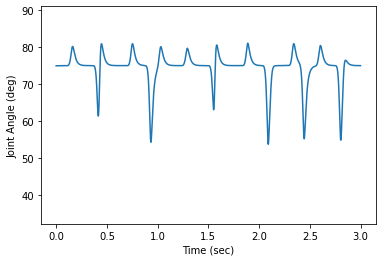

In [64]:
min_angle = np.min(np.rad2deg(x_mat[:,4]))
max_angle = np.max(np.rad2deg(x_mat[:,4]))
plt.plot(time_sim[0:30000],np.rad2deg(x_mat[0:30000,4]))
plt.ylabel('Joint Angle (deg)')
plt.xlabel('Time (sec)')
plt.ylim([min_angle-10, max_angle+10])

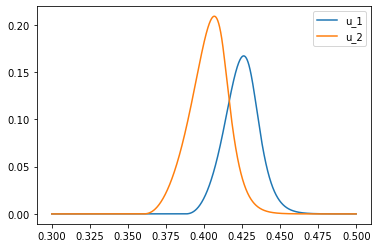

In [65]:
plt.plot(time_sim[3000:5000],x_mat[3000:5000,0],label='u_1')
plt.plot(time_sim[3000:5000],x_mat[3000:5000,2],label='u_2')
plt.legend()

array([-0., -0., -0., ..., -0., -0., -0.])